# Notebook to Prepare 1000 Genomes Data
This notebooks prepares the downsampled HDF5 for 1240k Data.
Requires bcftools binary.
Atm, only runs on Harald's local machine (where BCFtools is installed)
Runtime on one CPU: Ca. 15 Min for Chr. 3

In [1]:
import allel
import h5py  # Python Package to do the HDF5.
import numpy as np
import pandas as pd
import socket
import os as os
import sys as sys
import multiprocessing as mp

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Produce SNP file (file used for downsampling)
Needs to be run only once on each setup

# Prepare downsampled X hdf5s
Prepare a 1000 Genome X hdf5 file. Include Recombination Map
Input: 1000 Genome vcf file, Recombination Map from a 1240k Eigenstrat
## Standalone from here onward.

- Step 0: Download the Data
- Step 1: Produce hdf5 file for all markers
- Step 2: Extract Positions. Match with Eigenstrat File Positions
- Step 3: Create new vcf based on subset of Individuals and Markers
- Step 4: Transfer to hdf5. 
- Step 5: Merge in Linkage Map
- Step 6: Quality Check? (Control ref/alt against hdf5 we have for Sardinians)

In [124]:
### Step 0: Download the Data and produce SNP file
def produce_variant_file_X(snp_path, save_path):
    """Produces txt file listing names of all 1240k SNPs"""
    df_snp = pd.read_csv(snp_path, header=None,
                                 sep=r"\s+", engine="python")
    df_snp.columns = ["SNP", "chr", "map",
                      "pos", "ref", "alt"]  # Set the Columns

    df_snp = df_snp[df_snp["chr"]==23]
    df_snp = df_snp[2:] # Remove the first two SNPs (isolated on X)
    print(f"Loaded {len(df_snp)} X SNPs.")
    
    df_save = df_snp[["chr", "pos"]].copy()
    df_save.loc[:,"chr"] = "X"
    df_save.to_csv(save_path, sep="\t", header=False, index=False)
    print(f"Successfully saved to {save_path}. Length: {len(df_save)}")
    
### Step 1: Produce hdf5 file for all markers
def vcf_to_hdf5(in_path, out_path):
    """Transform Full VCF to full HDF5"""
    allel.vcf_to_hdf5(input=in_path, output=out_path, compression="gzip") # Takes 10 Minutes
    
### Step 2: Extract Positions. Match with Eigenstrat File Positions
### Load HDF5

def merge_positions():
    """Creates the Filter File to filter SNPs for"""
    f_full = h5py.File(path_hdf5temp, "r") # Load for Sanity Check. See below!
    print("Loaded %i variants" % np.shape(f_full["calldata/GT"])[0])
    print("Loaded %i individuals" % np.shape(f_full["calldata/GT"])[1])
    print(list(f_full["calldata"].keys()))
    print(list(f_full["variants"].keys()))
    #print(list(f["samples"].keys()))

    ### Load Eigenstrat
    df_snp = pd.read_csv(snp1240k_path, header=None, sep=r"\s+", engine="python")
    df_snp.columns = ["SNP", "chr", "map", "pos", "ref", "alt"]
    df_snp = df_snp[df_snp["chr"] == ch]
    print(f"Loaded {len(df_snp)} Chr.{ch} SNPs.")

    ### Prepare SNP File for Eigenstrat filtering 
    found = np.isin(f_full["variants/POS"], df_snp["pos"])
    print(f"Intersection: {np.sum(found)} out of {len(found)} SNPS")
    variants = f_full["variants/ID"][found]

    dots = np.where(variants == ".")[0]
    print(f"Found {len(dots)} unnamed SNPs")
    variants = np.delete(variants, dots)

    np.savetxt(snp_filter_path, variants, fmt="%s")
    print(f"Successfully saved to {snp_filter_path}. Length: {len(variants)}")
    
def save_1240kmarkers():
    """Save all 1240 Markers in csv"""
    df_snp = pd.read_csv(snp1240k_path, header=None, sep=r"\s+", engine="python")
    df_snp.columns = ["SNP", "chr", "map", "pos", "ref", "alt"]
    df_snp = df_snp[df_snp["chr"] == ch]
    print(f"Loaded {len(df_snp)} Chr.{ch} SNPs.")

    df_save = df_snp[["chr", "pos"]]
    df_save.to_csv(marker_path, sep="\t", header=None, index=False)
    print(f"Saved {len(df_save)} 1240k Markers on Chr. {ch} to {marker_path}")
    
### Step 3: Create new vcf based on subset of Individuals and Markers
def plink_new_vcf():
    """Extract 1240k 
    SNPs with Plink"""
    !plink --vcf $path_vcf100g --extract $snp_filter_path --keep-fam $ind_path --recode vcf --out $out_vcf_path0 --biallelic-only strict --keep-allele-order

### Step 3b
def bctools_new_vcf0():
    """Same as PLINK, but with bcftools 
    [small hack with marker strings, so LEGACY code and replaced by bcftools_new_vcf]"""
    str_ex = "ID=@" + snp_filter_path
    #!echo bcftools view -Oz -o $out_vcf_path_gz -S $ind_path -i $str_ex -m2 -M2 -v snps $path_vcf100g
    !bcftools view -Oz -o $out_vcf_path_gz -S $ind_path -i $str_ex -m2 -M2 -v snps $path_vcf100g
    print("Finished BCF tools runs.")
    
def bctools_new_vcf(filter_iids=True, cluster=False):
    """Same as PLINK, but with bcftools and directly via Marker Positions.
    filter_iids: Whether to use the .csv with Indivdiduals to extract"""
    if filter_iids==True:
        if cluster==False:
            !bcftools view -Oz -o $out_vcf_path_gz -S $ind_path -T $marker_path -m2 -M2 -v snps $path_vcf100g
        elif cluster==True:
            !module load bcftools; bcftools view -Oz -o $out_vcf_path_gz -S $ind_path -T $marker_path -m2 -M2 -v snps $path_vcf100g     
    elif filter_iids==False:
        if cluster==False:
            !bcftools view -Oz -o $out_vcf_path_gz -T $marker_path -m2 -M2 -v snps $path_vcf100g
        elif cluster==True:
            !module load bcftools; bcftools view -Oz -o $out_vcf_path_gz -T $marker_path -m2 -M2 -v snps $path_vcf100g
    print("Finished BCF tools runs.")

### Step 4: Transfer to hdf5.
#allel.vcf_to_hdf5(input=out_vcf_path, output=path_hdf5final, compression="gzip") # Takes 1s
 
### Step 5: Merge in Linkage Map
### Load HDF5
def merge_in_ld_map(ch=23):
    """Merge in ld_map into HDF5!"""
    f = h5py.File(path_hdf5final, "r") # Load for Sanity Check. See below!
    print("Merging in LD Map into HDF5...")
    print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
    print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
    print(list(f["calldata"].keys()))
    print(list(f["variants"].keys()))
    #print(list(f["samples"].keys()))

    ### Load Eigenstrat
    df_snp = pd.read_csv(snp1240k_path, header=None, sep=r"\s+", engine="python")
    df_snp.columns = ["SNP", "chr", "map", "pos", "ref", "alt"]
    df_snp = df_snp[df_snp["chr"] == ch]
    print(f"Loaded {len(df_snp)} Chr.{ch} SNPs.")

    ### Intersect SNP positions
    its, i1, i2 = np.intersect1d(f["variants/POS"], df_snp["pos"], return_indices=True)

    l = len(f["variants/POS"])
    print(f"Intersection {len(i2)} out of {l}")

    ### Extract 
    rec = np.zeros(len(f["variants/POS"]))
    rec[i1] = df_snp["map"].values[i2]  # Fill in the values in Recombination map
    ids0 = np.where(rec == 0)[0] # The 0 Values which should be filled in
    rec[ids0] = (rec[ids0-1] + rec[ids0+1]) / 2.0 # Interpolate

    ### Make sure that sorted
    assert(np.all(np.diff(rec)>=0))  # Assert the Recombination Map is sorted! (no 0 left and no funky stuff)

    f.close()
    with h5py.File(path_hdf5final, 'a') as f0:
        group = f0["variants"]
        group.create_dataset('MAP', (l,), dtype='f')   
        f0["variants/MAP"][:] = rec[:]

    print(f"Finished Chromosome {ch}")
    
### Step 6: Delete the Data:
def del_temp_data():
    !rm $path_vcf100g # Delete the full 1000 genome .vcf
    !rm $out_vcf_path_gz # Delete the extracted .vcf
    #!rm $path_hdf5temp # The originally intermediate hdf5 (for 1240k intersection)

# Prepare Paths

In [125]:
### Important Parameters and paths
ch = 3 # Which Chromosome to use:

# Path of the 1000 Genome VCF:
p1, p2 = "", ""
file_vcf100g, path_vcf100g = "", ""
out_vcf_path0, out_vcf_path = "", ""
path_hdf5temp, path_hdf5final = "", ""

snp1240k_path, ind_path = "", ""   # Where to find the 1240k SNPs
snp_filter_path = ""

def prepare_paths_X():
    """Prepares all the Paths need for processing Steps.
    ch: Which Chromosomes to use"""
    global file_vcf100g, path_vcf100g, out_vcf_path0, out_vcf_path, path_hdf5temp, path_hdf5final
    global snp1240k_path, ind_path, snp_filter_path, out_vcf_path_gz, marker_path
    # Path of the 1000 Genome VCF:
    path_vcf100g = "./Data/1000Genomes/X_VCF/ALL.chrX.phase3_shapeit2_mvncall_integrated_v1b.20130502.genotypes.vcf.gz"
    print(f"Full Input path:\n{path_vcf100g}")
    out_vcf_path0 = "./Data/1000Genomes/X_VCF/Subset/1240all/chrX"
    out_vcf_path = out_vcf_path0 + ".vcf"
    out_vcf_path_gz = out_vcf_path + ".gz"
    path_hdf5temp = "./Data/1000Genomes/HDF5/FULLHDF5/cr" + "X" + ".hdf5"
    path_hdf5final = "./Data/1000Genomes/HDF5/1240kHDF5/all1240/chrX.hdf5"
    snp1240k_path = "./Data/1000Genomes/Markers/MinMyc.snp"   # Where to find the 1240k SNPs
    ind_path = "./Data/1000Genomes/Individuals/NO_EXIST.csv"  # non-existing place-holder (sanity check)
    marker_path = "./Data/1000Genomes/Markers/1240k/chrX.csv"
    
    for path in [out_vcf_path, path_hdf5final]:
        path_dir = os.path.dirname(path)
    
        if not os.path.exists(path_dir):
            os.makedirs(path_dir)
            print(f"Created new directory: {path_dir}")
    
    ### Path of SNP Filter
    snp_filter_path = "../Data/1000Genomes/Markers/variants1240k" + str(ch) + ".txt"

# Do all steps to extract X reference panel
(one by one)

In [126]:
produce_variant_file_X(snp_path = "./Data/1000Genomes/Markers/MinMyc.snp",
                       save_path = "./Data/1000Genomes/Markers/1240k/chrX.csv")

Loaded 49702 X SNPs.
Successfully saved to ./Data/1000Genomes/Markers/1240k/chrX.csv. Length: 49702


In [127]:
prepare_paths_X()

Full Input path:
./Data/1000Genomes/X_VCF/ALL.chrX.phase3_shapeit2_mvncall_integrated_v1b.20130502.genotypes.vcf.gz


In [128]:
%%time
### Takes about 8 min
bctools_new_vcf(filter_iids=False, cluster=True)  # Important, turn off filter individuals here!

[W::hts_idx_load2] The index file is older than the data file: ./Data/1000Genomes/X_VCF/ALL.chrX.phase3_shapeit2_mvncall_integrated_v1b.20130502.genotypes.vcf.gz.tbi
Finished BCF tools runs.
CPU times: user 11.6 s, sys: 1.78 s, total: 13.4 s
Wall time: 7min 58s


In [131]:
%%time
vcf_to_hdf5(in_path=out_vcf_path_gz, out_path=path_hdf5final)

CPU times: user 10.3 s, sys: 403 ms, total: 10.7 s
Wall time: 10.8 s


In [132]:
%%time
merge_in_ld_map(ch=23)

Merging in LD Map into HDF5...
Loaded 47898 variants
Loaded 2504 individuals
['GT']
['ALT', 'CHROM', 'FILTER_PASS', 'ID', 'POS', 'QUAL', 'REF']
Loaded 49704 Chr.23 SNPs.
Intersection 47895 out of 47898
Finished Chromosome 23
CPU times: user 9.13 s, sys: 285 ms, total: 9.41 s
Wall time: 9.44 s


In [133]:
print(f"Final file at: {path_hdf5final}")

Final file at: ./Data/1000Genomes/HDF5/1240kHDF5/all1240/chrX.hdf5


In [ ]:
#del_temp_data()

# Prepare Metafile with Sex [Standalone]

In [ ]:
df = pd.read_csv('./Data/1000Genomes/Individuals/meta_df_all.csv', sep="\t")
pop_path = "./Data/1000Genomes/integrated_call_samples_v3.20130502.ALL.panel" # Population Information
df_pops = pd.read_csv(pop_path, sep="\t")
print(f"Loaded {np.shape(df_i)[0]} Population Data")

df_m = pd.merge(df, df_pops[["sample", "gender"]], on="sample", how="left")

savepath="./Data/1000Genomes/Individuals/meta_df_all_sex.tsv"
df_m.to_csv(savepath, sep="\t")
print(f"Save {len(df_m)} Meta Data rows to {savepath}")

# Area 51

In [51]:
### Load hdf5 File

In [119]:
path_load = "./Data/1000Genomes/HDF5/1240kHDF5/all1240/chrX.hdf5"
#path_load = "./Data/SA_1240kHDF5/IPK12_downsample_ph.h5"
f = h5py.File(path_load, "r") # Load for Sanity Check. See below!
        
print("Loaded HDF5")
print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

Loaded HDF5
Loaded 47900 variants
Loaded 2504 individuals
['GT']
['ALT', 'CHROM', 'FILTER_PASS', 'ID', 'MAP', 'POS', 'QUAL', 'REF']


In [122]:
f["variants/MAP"][:10]

array([0.071651, 0.145112, 0.208504, 0.208896, 0.208974, 0.209002,
       0.209031, 0.20918 , 0.209643, 0.209646], dtype=float32)

In [121]:
f["calldata/GT"][303,1000:1010,:]

array([[ 1, -1],
       [ 1, -1],
       [ 0,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0, -1],
       [ 0,  0],
       [ 0, -1],
       [ 0,  1],
       [ 0, -1]], dtype=int8)

In [94]:
missing = np.sum(f["calldata/GT"][:]==-1, axis=0)

In [95]:
np.shape(missing)

(2504, 2)

In [101]:
missing[:,1]

array([47825,     0,     0, ...,     0,     0,     0])

In [99]:
import matplotlib.pyplot as plt

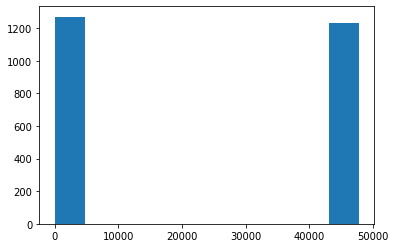

In [102]:
plt.figure()
plt.hist(missing[:,1])
plt.show()

In [116]:
f.close()